In [1]:
import dask.dataframe as dd
from datetime import datetime
import intake
import numpy as np
import pandas as pd

In [2]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [3]:
import intake
from tqdm import tqdm

# cat = intake.Catalog('https://raw.githubusercontent.com/ContinuumIO/anaconda-package-data/master/catalog/anaconda_package_data.yaml')
# monthly = cat.anaconda_package_data_by_month(year=2019, month=12).to_dask()

In [4]:
datetime_count = {}

In [5]:
for year in tqdm([2017, 2018, 2019, 2020]):
    for month in range(1, 13):
        try:
            df = intake.cat.anaconda_package_data_by_month(year=year, month=month).to_dask()
        except IndexError:
            break
        datetime_count[(year, month)] = df.loc[(df.data_source=='conda-forge')]['counts'].sum().compute()

  0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  4.2s


 25%|██▌       | 1/4 [02:49<08:29, 169.91s/it]

[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  6.2s


 50%|█████     | 2/4 [06:06<05:55, 177.89s/it]

[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  7.9s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.9s


 75%|███████▌  | 3/4 [09:55<03:13, 193.29s/it]

[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  9.7s
[########################################] | 100% Completed | 11.1s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed | 10.4s
[########################################] | 100% Completed | 10.0s
[########################################] | 100% Completed |  9.7s


100%|██████████| 4/4 [13:10<00:00, 197.67s/it]


In [6]:
datetime_count

{(2017, 1): 0,
 (2017, 2): 0,
 (2017, 3): 701645,
 (2017, 4): 7375445,
 (2017, 5): 8261383,
 (2017, 6): 7535179,
 (2017, 7): 10039857,
 (2017, 8): 12408943,
 (2017, 9): 11690260,
 (2017, 10): 13837261,
 (2017, 11): 13064540,
 (2017, 12): 11730379,
 (2018, 1): 17343201,
 (2018, 2): 18564943,
 (2018, 3): 21064271,
 (2018, 4): 16748850,
 (2018, 5): 24040170,
 (2018, 6): 23831192,
 (2018, 7): 28815251,
 (2018, 8): 32511378,
 (2018, 9): 37050898,
 (2018, 10): 47325248,
 (2018, 11): 50874921,
 (2018, 12): 42107025,
 (2019, 1): 43062229,
 (2019, 2): 46763206,
 (2019, 3): 55879507,
 (2019, 4): 48684136,
 (2019, 5): 66728803,
 (2019, 6): 62462089,
 (2019, 7): 65210830,
 (2019, 8): 61969868,
 (2019, 9): 62608046,
 (2019, 10): 78757103,
 (2019, 11): 85271670,
 (2019, 12): 90225074,
 (2020, 1): 99275455,
 (2020, 2): 99000914,
 (2020, 3): 115990884,
 (2020, 4): 122603668,
 (2020, 5): 117375623,
 (2020, 6): 120825988,
 (2020, 7): 126489061,
 (2020, 8): 150563060,
 (2020, 9): 162411810}

In [7]:
datetime_count = {k: v for k, v in datetime_count.items() if v}

In [8]:
import pandas as pd

In [9]:
years = [k[0] for k in datetime_count]
months = [k[1] for k in datetime_count]
counts = [datetime_count[k] for k in zip(years, months)]

In [10]:
cdf = pd.DataFrame({'year': years, 'months': months, 'day': [1] * len(years)})

In [11]:
cdf['idx'] = pd.to_datetime(cdf)

In [12]:
cdf = cdf.set_index('idx')

In [13]:
cdf['counts'] = counts

In [14]:
import matplotlib.pyplot as plt

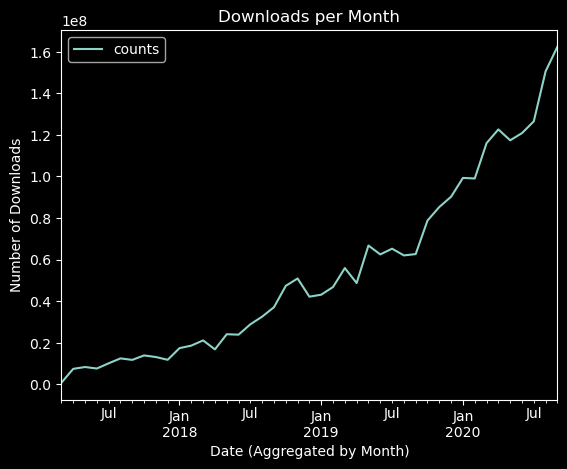

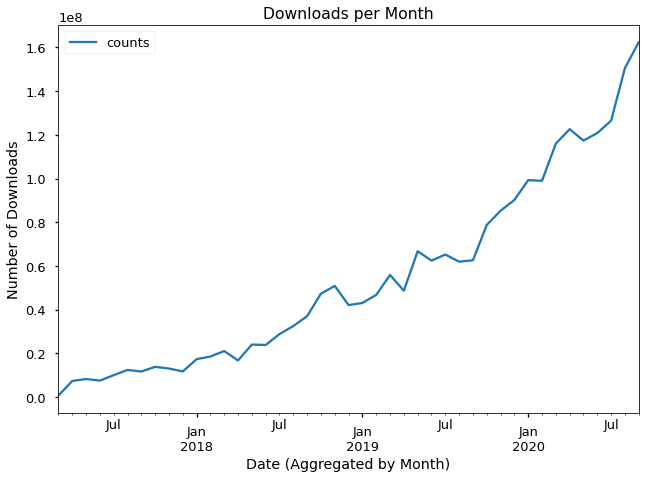

In [15]:
for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        cdf.plot(y='counts', ax=ax)
        ax.set_title(f"Downloads per Month")
        ax.set_xlabel("Date (Aggregated by Month)")
        ax.set_ylabel("Number of Downloads")
        fig.savefig(f"plots/downloads-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)

In [16]:
cdf['counts'].sum()/1e9

2.339081264

In [17]:
cdf['counts'] / 1e6

idx
2017-03-01      0.701645
2017-04-01      7.375445
2017-05-01      8.261383
2017-06-01      7.535179
2017-07-01     10.039857
2017-08-01     12.408943
2017-09-01     11.690260
2017-10-01     13.837261
2017-11-01     13.064540
2017-12-01     11.730379
2018-01-01     17.343201
2018-02-01     18.564943
2018-03-01     21.064271
2018-04-01     16.748850
2018-05-01     24.040170
2018-06-01     23.831192
2018-07-01     28.815251
2018-08-01     32.511378
2018-09-01     37.050898
2018-10-01     47.325248
2018-11-01     50.874921
2018-12-01     42.107025
2019-01-01     43.062229
2019-02-01     46.763206
2019-03-01     55.879507
2019-04-01     48.684136
2019-05-01     66.728803
2019-06-01     62.462089
2019-07-01     65.210830
2019-08-01     61.969868
2019-09-01     62.608046
2019-10-01     78.757103
2019-11-01     85.271670
2019-12-01     90.225074
2020-01-01     99.275455
2020-02-01     99.000914
2020-03-01    115.990884
2020-04-01    122.603668
2020-05-01    117.375623
2020-06-01    120.825